In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install torch torchvision


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from PIL import Image


In [ ]:
# Define paths to the dataset
data_dir = '/content/drive/MyDrive/Dataset'  # Adjust this path to your dataset folder
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')


In [ ]:
# Define image transformations
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [ ]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=transform['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=transform['test'])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class names (based on folder names)
class_names = train_dataset.classes
print("Class Names:", class_names)  # Should output ['dog', 'fox', 'hyena', 'wolf']


Class Names: ['dog', 'fox', 'hyena', 'wolves']


In [ ]:
# Load pre-trained ResNet model
model = models.resnet50(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # 4 classes

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 88.5MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [ ]:
num_epochs = 4

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Validation Accuracy: {100 * correct / total:.2f}%')


Epoch [1/4], Loss: 0.4458
Validation Accuracy: 92.23%
Epoch [2/4], Loss: 0.2643
Validation Accuracy: 92.04%
Epoch [3/4], Loss: 0.2477
Validation Accuracy: 92.62%
Epoch [4/4], Loss: 0.2291
Validation Accuracy: 92.04%


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")


Test Accuracy: 91.73%
Test Recall: 0.92
Test F1 Score: 0.92


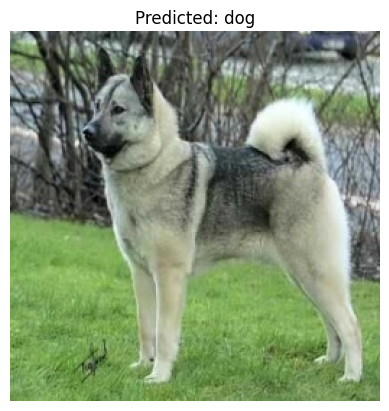

In [ ]:
def predict_image(image_path):
    # Load and process the image
    image = Image.open(image_path).convert("RGB")
    image = transform['test'](image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)  # Move to GPU if available

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    # Get the predicted class
    predicted_class = class_names[predicted.item()]
    return predicted_class

def display_prediction(image_path):
    predicted_class = predict_image(image_path)

    # Display the image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')  # Hide axis
    plt.title(f'Predicted: {predicted_class}')  # Show prediction
    plt.show()

# Example usage
test_image_path = '/content/drive/MyDrive/Dataset/test/dog/0DXX8OW2LNNH.jpg'  # Replace with your image path
display_prediction(test_image_path)


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install necessary libraries
!pip install torch torchvision

# Import libraries
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, recall_score, f1_score
import numpy as np

# Define paths to the dataset
data_dir = '/content/drive/MyDrive/Dataset'  # Path to your dataset
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Define image transformations
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=transform['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=transform['test'])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class names (based on folder names)
class_names = train_dataset.classes  # Expected to be ['dog', 'fox', 'hyena', 'wolf']
print("Class Names:", class_names)

# Load pre-trained ResNet model
model = models.resnet50(pretrained=True)

# Freeze all layers in ResNet
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer for our 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # 4 classes

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training and validation phases
num_epochs = 4
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Validation Accuracy: {100 * correct / total:.2f}%')

# Test phase and calculating metrics (accuracy, recall, F1 score)
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")

# Optional: Display per-class accuracy
class_correct = np.zeros(len(class_names))
class_total = np.zeros(len(class_names))

# Compute per-class accuracy
for i in range(len(y_true)):
    label = y_true[i]
    class_total[label] += 1
    if y_pred[i] == label:
        class_correct[label] += 1

# Display accuracy for each class
for i, class_name in enumerate(class_names):
    accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"Accuracy for {class_name}: {accuracy:.2f}%")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Class Names: ['dog', 'fox', 'hyena', 'wolves']


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


Epoch [1/4], Loss: 0.4448
Validation Accuracy: 91.75%
Epoch [2/4], Loss: 0.2667
Validation Accuracy: 91.18%
Epoch [3/4], Loss: 0.2614
Validation Accuracy: 93.19%
Epoch [4/4], Loss: 0.2358
Validation Accuracy: 92.23%
Test Accuracy: 92.14%
Test Recall: 0.92
Test F1 Score: 0.92
Accuracy for dog: 94.67%
Accuracy for fox: 94.67%
Accuracy for hyena: 94.00%
Accuracy for wolves: 85.44%
